<a href="https://colab.research.google.com/github/ericzhangxii/AlphaZero-Chess-Implementation/blob/main/TensorFlow_AlphaZero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [249]:
!pip install tensorflow
!pip install chess
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


OK so presumably the pseudocode is just a suggestion which you override later.

Y'know what, the whole overpromotions/underpromotions thing is just super annoying. Just gonna ignore actually.

Also note, you can just have empty planes if you want. It's fine, nothing bad actually happens.

Another note: wow just coding the damn thing was a lot easier than debugging it!

What's going on here?

Observe a problem: wow it gets slow
Hypothesis: is it the deepcopy thing?

# Network

In [153]:
import copy
import chess
import numpy as np
import random
import tqdm
from tqdm import tqdm
import os
import time
import chess.svg
from IPython.display import SVG, display, clear_output
import pickle

def print_board(board):
    # Clear previous console output
    clear_output(wait=True)
    # Display the board
    display(SVG(chess.svg.board(board=board,size=300)))


In [245]:
# The Real Chess Network
from tensorflow.keras.layers import BatchNormalization

class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(num_filters, kernel_size=3, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(num_filters, kernel_size=3, padding='same')
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        x = self.bn1(self.conv1(inputs))
        x = tf.nn.relu(x)
        x = self.bn2(self.conv2(x))
        x = Add()([inputs, x])
        return tf.nn.relu(x)

class ChessNet:
    def __init__(self, input_shape=(8,8,119), num_res_blocks=0, num_filters=256):
        inputs = Input(shape=input_shape)

        x = Conv2D(num_filters, kernel_size=3, padding='same')(inputs)
        x = BatchNormalization()(x)
        x = tf.nn.relu(x)

        for _ in range(num_res_blocks):
            x = ResidualBlock(num_filters)(x)

        # Policy head
        policy_conv = Conv2D(2, kernel_size=1, padding='same')(x)
        policy_conv = BatchNormalization()(policy_conv)
        policy_conv = tf.nn.relu(policy_conv)
        policy_flatten = Flatten()(policy_conv)
        policy_output = Dense(8*8*76, activation='softmax')(policy_flatten)
        policy_output = tf.reshape(policy_output, [-1, 8, 8, 76])

        # Value head
        value_conv = Conv2D(1, kernel_size=1, padding='same')(x)
        value_conv = BatchNormalization()(value_conv)
        value_conv = tf.nn.relu(value_conv)
        value_flatten = Flatten()(value_conv)
        value_hidden = Dense(256, activation='relu')(value_flatten)
        value_output = Dense(1, activation='tanh')(value_hidden)

        self.model = Model(inputs=inputs, outputs=[value_output, policy_output])

    def get_weights(self):
        return self.model.get_weights()

    def inference(self, image):
      value, policy = self.model.predict(tf.expand_dims(image,axis=0))
      return value[0][0], tensor_to_moves_dict(policy[0])



In [234]:
#The Minimum Chess Network

# The Real Chess Network
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Add, Input, BatchNormalization
from tensorflow.keras.models import Model

class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, num_filters):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv2D(num_filters, kernel_size=3, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(num_filters, kernel_size=3, padding='same')
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        x = self.bn1(self.conv1(inputs))
        x = tf.nn.relu(x)
        x = self.bn2(self.conv2(x))
        x = Add()([inputs, x])
        return tf.nn.relu(x)

class ChessNet0:
    def __init__(self, input_shape=(8,8,119), num_res_blocks=0, num_filters=1):
        inputs = Input(shape=input_shape)

        # Policy head
        policy_output = Dense(4864, activation='softmax')(inputs)
        policy_output = tf.reshape(policy_output, [-1, 8, 8, 76])

        # Value head
        value_output = Dense(1, activation='tanh')(inputs)

        self.model = Model(inputs=inputs, outputs=[value_output,policy_output])

    def get_weights(self):
        return self.model.get_weights()

    def inference(self, image):
      value, policy = self.model.predict(tf.expand_dims(image,axis=0))
      return value, tensor_to_moves_dict(policy[0])


In [220]:
mynet = ChessNet0()
mynet.model.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 8, 8, 119)]  0           []                               
                                                                                                  
 dense_2376 (Dense)             (None, 8, 8, 4864)   583680      ['input_35[0][0]']               
                                                                                                  
 dense_2377 (Dense)             (None, 8, 8, 1)      120         ['input_35[0][0]']               
                                                                                                  
 tf.reshape_33 (TFOpLambda)     (None, 8, 8, 76)     0           ['dense_2376[0][0]']             
                                                                                           

In [183]:


"""Pseudocode description of the AlphaZero algorithm."""

import math
import numpy
import tensorflow as tf
from typing import List

##########################
####### Helpers ##########


class AlphaZeroConfig(object):

  def __init__(self):
    ### Self-Play
    self.num_actors = 1

    self.num_sampling_moves = 30
    self.max_moves = 1000  # for chess and shogi, 722 for Go.
    self.num_simulations = 1
    self.max_games = 100

    # Root prior exploration noise.
    self.root_dirichlet_alpha = 0.3  # for chess, 0.03 for Go and 0.15 for shogi.
    self.root_exploration_fraction = 0.25

    # UCB formula
    self.pb_c_base = 19652
    self.pb_c_init = 1.25

    ### Training
    self.training_steps = int(700e3)
    self.checkpoint_interval = int(1e3)
    self.window_size = int(1e6)
    self.batch_size = 4096

    self.weight_decay = 1e-4
    self.momentum = 0.9
    # Schedule for chess and shogi, Go starts at 2e-2 immediately.
    self.learning_rate_schedule = {
        0: 2e-1,
        100e3: 2e-2,
        300e3: 2e-3,
        500e3: 2e-4
    }

    self.random_setting = 2

class Node(object):
  def __init__(self, prior: float):
    self.visit_count = 0
    self.to_play = -1
    self.prior = prior
    self.value_sum = 0
    self.children = {}

  def expanded(self):
    return len(self.children) > 0

  def value(self):
    if self.visit_count == 0:
      return 0
    return self.value_sum / self.visit_count

class ChessGame(object):
  def __init__(self, history=None, state_history=None):
    self.history = history or []
    self.state_history = state_history or [chess.Board()]
    self.child_visits = []
    self.num_actions = 4672

  def terminal(self):
    if(self.state_history[-1].is_game_over()):
      return True
    else:
      return False

  def terminal_value(self, to_play):
    if(self.terminal()):
      if(self.state_history[-1].is_checkmate()):
        if(to_play==self.to_play):
          return -1
        else:
          return 1
      else:
        return 0

  def legal_actions(self):
    return list(self.state_history[-1].legal_moves)

  def clone(self):
    return ChessGame(list(self.history),list(self.state_history))

  def apply(self, action):
    self.history.append(action)
    boardcopy = copy.deepcopy(self.state_history[-1])
    boardcopy.push(action)
    self.state_history.append(boardcopy)

  def store_search_statistics(self, root):
    sum_visits = sum(child.visit_count for child in root.children.values())
    self.child_visits.append([
        root.children[a].visit_count / sum_visits if a in root.children else 0
        for a in range(self.num_actions)
    ])

  def make_image(self, state_index):
    hist_slice = get_items_up_to_index(self.state_history, state_index)
    image = create_tensor(hist_slice)
    return image

  def random_move(self):
    random_action = random.choice(self.legal_actions())
    return random_action

  def to_play(self):
    return len(self.state_history)%2 - 1

class ReplayBuffer(object):
  def __init__(self, config: AlphaZeroConfig):
    self.window_size = config.window_size
    self.batch_size = config.batch_size
    self.buffer = []
    try:
      with open('replay_buffer.pkl','rb') as f:
        self.buffer = pickle.load(f)
    except:
      pass

  def save_game(self, game):
    if len(self.buffer) > self.window_size:
      self.buffer.pop(0)
    self.buffer.append(game)
    with open('replay_buffer.pkl','wb') as f:
      pickle.dump(self.buffer,f)

  def sample_batch(self):
    # Sample uniformly across positions.
    move_sum = float(sum(len(g.history) for g in self.buffer))
    games = numpy.random.choice(
        self.buffer,
        size=self.batch_size,
        p=[len(g.history) / move_sum for g in self.buffer])
    game_pos = [(g, numpy.random.randint(len(g.history))) for g in games]
    return [(g.make_image(i), g.make_target(i)) for (g, i) in game_pos]


class Network(object):

  def inference(self, image):
    return (-1, {})  # Value, Policy

  def get_weights(self):
    # Returns the weights of this network.
    return []


class SharedStorage(object):

  def __init__(self):
    self._networks = {}

  def latest_network(self) -> Network:
    if self._networks:
      return self._networks[max(self._networks.keys())]
    else:
      return ChessNet()  # policy -> uniform, value -> 0.5

  def save_network(self, step: int, network: Network):
    print("Saving Network!")
    self._networks[step] = network

def save_object(myObject, object_name):
  with open(f'{object_name}.pkl','wb') as f:
    pickle.dump(myObject,f)

##### End Helpers ########
##########################


# AlphaZero training is split into two independent parts: Network training and
# self-play data generation.
# These two parts only communicate by transferring the latest network checkpoint
# from the training to the self-play, and the finished games from the self-play
# to the training.
def alphazero(config: AlphaZeroConfig):
  storage = SharedStorage()
  replay_buffer = ReplayBuffer(config)

  for i in range(config.num_actors):
    launch_job(run_selfplay, config, storage, replay_buffer)

  train_network(config, storage, replay_buffer)

  return storage.latest_network()


##################################
####### Part 1: Self-Play ########


# Each self-play job is independent of all others; it takes the latest network
# snapshot, produces a game and makes it available to the training job by
# writing it to a shared replay buffer.
def run_selfplay(config: AlphaZeroConfig, storage: SharedStorage,
                 replay_buffer: ReplayBuffer):
  while (len(replay_buffer.buffer)<config.max_games):
    network = storage.latest_network()
    game = play_game(config, network,replay_buffer.buffer)
    replay_buffer.save_game(game)


# Each game is produced by starting at the initial board position, then
# repeatedly executing a Monte Carlo Tree Search to generate moves until the end
# of the game is reached.

def play_game(config: AlphaZeroConfig, network: Network, buffer=None):
  game = ChessGame()
  while not game.terminal() and len(game.state_history) < config.max_moves:
    action, root = run_mcts(config, game, network)
    game.apply(action)
    board = game.state_history[-1]
    clear_output(wait=True)
    display(SVG(chess.svg.board(board=board,size=300)))
    if(buffer):
      print("Game Number: " + str(len(buffer)))
      print("Checkmates: " + str(sum([game.state_history[-1].is_checkmate() for game in buffer])))
    print("Action: " + str(action))
    print("Move: " + str(len(game.state_history)))
    print("To Move: " + str(board.turn))
    game.store_search_statistics(root)
  return game


# Core Monte Carlo Tree Search algorithm.
# To decide on an action, we run N simulations, always starting at the root of
# the search tree and traversing the tree according to the UCB formula until we
# reach a leaf node.
def run_mcts(config: AlphaZeroConfig, game: ChessGame, network: Network):
  root = Node(0)
  evaluate(root, game, network)
  add_exploration_noise(config, root)

  for _ in range(config.num_simulations):
    node = root
    scratch_game = game.clone()
    search_path = [node]

    while node.expanded():
      action, node = select_child(config, node)
      scratch_game.apply(action)
      search_path.append(node)

    value = evaluate(node, scratch_game, network)
    backpropagate(search_path, value, scratch_game.to_play())
  return select_action(config, game, root), root


def select_action(config: AlphaZeroConfig, game: ChessGame, root: Node):
  visit_counts = [(child.visit_count, action)
                  for action, child in root.children.items()]
  if len(game.history) < config.num_sampling_moves:
    _, action = softmax_sample(visit_counts)
  else:
    _, action = max(visit_counts, key=lambda item:item[0])
  return action


# Select the child with the highest UCB score.
def select_child(config: AlphaZeroConfig, node: Node):
  childlist = [(ucb_score(config, node, child), action, child)
                         for action, child in node.children.items()]
  _, action, child = max(childlist, key=lambda item:item[0])
  return action, child


# The score for a node is based on its value, plus an exploration bonus based on
# the prior.
def ucb_score(config: AlphaZeroConfig, parent: Node, child: Node):
  pb_c = math.log((parent.visit_count + config.pb_c_base + 1) /
                  config.pb_c_base) + config.pb_c_init
  pb_c *= math.sqrt(parent.visit_count) / (child.visit_count + 1)

  prior_score = pb_c * child.prior
  value_score = child.value()
  return prior_score + value_score


# We use the neural network to obtain a value and policy prediction.
def evaluate(node: Node, game: ChessGame, network: Network):
  value, policy_logits = network.inference(game.make_image(-1))

  # Expand the node.
  node.to_play = game.to_play()
  policy = {a: math.exp(policy_logits[a]) for a in game.legal_actions()}
  policy_sum = sum(policy.values())
  for action, p in policy.items():
    node.children[action] = Node(p / policy_sum)
  return value


# At the end of a simulation, we propagate the evaluation all the way up the
# tree to the root.
def backpropagate(search_path: List[Node], value: float, to_play):
  for node in search_path:
    node.value_sum += value if node.to_play == to_play else (1 - value)
    node.visit_count += 1


# At the start of each search, we add dirichlet noise to the prior of the root
# to encourage the search to explore new actions.
def add_exploration_noise(config: AlphaZeroConfig, node: Node):
  actions = node.children.keys()
  noise = numpy.random.gamma(config.root_dirichlet_alpha, 1, len(actions))
  frac = config.root_exploration_fraction
  for a, n in zip(actions, noise):
    node.children[a].prior = node.children[a].prior * (1 - frac) + n * frac


######### End Self-Play ##########
##################################

##################################
####### Part 2: Training #########


def train_network(config: AlphaZeroConfig, storage: SharedStorage,
                  replay_buffer: ReplayBuffer):
  network = ChessNet()
  optimizer = tf.compat.v1.train.MomentumOptimizer(config.learning_rate_schedule,
                                         config.momentum)
  print("Training Network")
  for i in range(config.training_steps):
    if i % config.checkpoint_interval == 0:
      storage.save_network(i, network)
    batch = replay_buffer.sample_batch()
    update_weights(optimizer, network, batch, config.weight_decay)
  print("Network Saved")
  storage.save_network(config.training_steps, network)


def update_weights(optimizer: tf.compat.v1.train.Optimizer, network: Network, batch,
                   weight_decay: float):
  loss = 0
  for image, (target_value, target_policy) in batch:
    value, policy_logits = network.inference(image)
    loss += (
        tf.losses.mean_squared_error(value, target_value) +
        tf.nn.softmax_cross_entropy_with_logits(
            logits=policy_logits, labels=target_policy))

  for weights in network.get_weights():
    loss += weight_decay * tf.nn.l2_loss(weights)

  optimizer.minimize(loss)


######### End Training ###########
##################################

################################################################################
############################# End of pseudocode ################################
################################################################################


# Stubs to make the typechecker happy, should not be included in pseudocode
# for the paper.


def softmax_sample(visit_counts):
    # Separate the visit counts and actions
    counts, actions = zip(*visit_counts)
    # Convert counts to float
    counts = tf.constant(counts, dtype=tf.float16)
    # Convert counts to probabilities using softmax
    probabilities = tf.nn.softmax(counts).numpy()
    # Select an index according to these probabilities
    selected_index = np.random.choice(len(actions), p=probabilities)
    # Return the corresponding visit count and action
    return visit_counts[selected_index]



def launch_job(f, *args):
  f(*args)


def make_uniform_network():
  return Network()



import chess
import numpy as np

def board_to_planes(board):
    planes = np.zeros((8, 8, 14), dtype=float)

    for i in range(64):
        pp = board.piece_at(i)
        if pp is not None:
            color = int(pp.color)
            piece_type = pp.piece_type
            row = i // 8
            col = i % 8
            planes[row][col][(piece_type - 1) + color * 7] = 1
    return planes

def create_tensor(board_history):
    tensor = np.zeros((8, 8, 14*8+7), dtype=float)
    reverse_hist = board_history[::-1]

    for i in range(8):
      if(i<len(reverse_hist)):
        board = reverse_hist[i]
        tensor[:, :, (i*14):(i*14+14)] = board_to_planes(board)

    board = board_history[-1]  # Most recent board state
    tensor[:, :, 112] = int(board.turn)
    tensor[:, :, 113] = board.fullmove_number
    tensor[:, :, 114] = int(board.has_kingside_castling_rights(chess.WHITE))
    tensor[:, :, 115] = int(board.has_queenside_castling_rights(chess.WHITE))
    tensor[:, :, 116] = int(board.has_kingside_castling_rights(chess.BLACK))
    tensor[:, :, 117] = int(board.has_queenside_castling_rights(chess.BLACK))
    tensor[:, :, 118] = board.halfmove_clock

    return tensor

def get_items_up_to_index(lst, index):
    if index < 0:
        index = len(lst) + index
    return lst[:index+1]

import numpy as np

def tensor_to_moves_dict(tensor):
  moves_dict = {}
  directions = [(0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1)]
  knight_offsets = [(1, 2), (2, 1), (2, -1), (1, -2), (-1, -2), (-2, -1), (-2, 1), (-1, 2)]
  for from_square in range(64):
    idx = 0
    from_rank, from_file = divmod(from_square, 8)

    #Queen Moves
    for (dx,dy) in directions:
      for steps in range(1,8):
        to_file = from_file + steps*dx
        to_rank = from_rank + steps*dy
        if(0<=to_file<8 and 0<= to_rank < 8):
          to_square = to_rank * 8 + to_file
          move = chess.Move(from_square, to_square)
          moves_dict[move] = tensor[from_file, from_rank, idx]
          idx += 1
    #Knight Moves
    for dx, dy in knight_offsets:
      to_file = from_file + dx
      to_rank = from_rank + dy
      if(0<= to_file < 8 and 0<= to_rank <8):
        to_square = to_rank*8 + to_file
        move = chess.Move(from_square, to_square)
        moves_dict[move] = tensor[from_rank, from_file, idx]
        idx += 1
    #Promotions
    if(from_rank in [1,6]):
      for promo_piece in [chess.QUEEN, chess.ROOK, chess.BISHOP, chess.KNIGHT]:
        for dx in [-1, 0, 1]:
          to_file = from_file + dx
          to_rank = 0 if from_rank==1 else 7
          if(0 <= to_file <8):
            to_square = to_file + 8*to_rank
            move = chess.Move(from_square, to_square, promotion=promo_piece)
            moves_dict[move] = tensor[from_file, from_rank, idx]
            idx += 1
  return moves_dict



# Testing

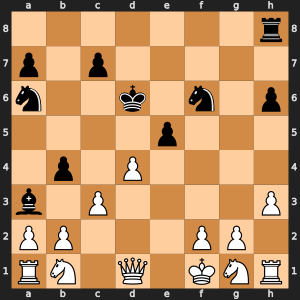

Game Number: 16
Checkmates: 0
Action: h2h1
Move: 44
To Move: False
1/1 [==============================] - 0s 28ms/step


KeyboardInterrupt: ignored

In [244]:
config = AlphaZeroConfig()
config.max_games = 50
config.num_simulations = 2
run_selfplay(config, SharedStorage(),ReplayBuffer(config))


In [131]:
with open('replay_buffer.pkl', 'rb') as f:
    loaded_replay_buffer = pickle.load(f)
result_list = [game.state_history[-1].is_checkmate() for game in loaded_replay_buffer]
print(str(sum(result_list)) + " out of " + str(len(result_list)))
print(result_list)

0 out of 71
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


1 sim: 0/71


In [248]:
mynet = ChessNet((8,8,119))
game = ChessGame()
image = game.make_image(-1)
value, policy = mynet.inference(image)
print(value)
print(policy)

1/1 [==============================] - 0s 138ms/step
-0.007788439
{Move.from_uci('a1a2'): 0.00020531238, Move.from_uci('a1a3'): 0.00020669139, Move.from_uci('a1a4'): 0.00020523192, Move.from_uci('a1a5'): 0.00020492547, Move.from_uci('a1a6'): 0.00020508259, Move.from_uci('a1a7'): 0.00020624777, Move.from_uci('a1a8'): 0.00020491815, Move.from_uci('a1b2'): 0.00020628759, Move.from_uci('a1c3'): 0.00020627695, Move.from_uci('a1d4'): 0.00020436449, Move.from_uci('a1e5'): 0.00020482976, Move.from_uci('a1f6'): 0.000205873, Move.from_uci('a1g7'): 0.00020819552, Move.from_uci('a1h8'): 0.00020549871, Move.from_uci('a1b1'): 0.00020490591, Move.from_uci('a1c1'): 0.00020586586, Move.from_uci('a1d1'): 0.00020589615, Move.from_uci('a1e1'): 0.00020422699, Move.from_uci('a1f1'): 0.00020507236, Move.from_uci('a1g1'): 0.00020623955, Move.from_uci('a1h1'): 0.00020422137, Move.from_uci('a1b3'): 0.00020725619, Move.from_uci('a1c2'): 0.00020659593, Move.from_uci('b1b2'): 0.00020783478, Move.from_uci('b1b3'): 

Note: OK so the second method actually does run substantially faster.

What lessons can I learn from this weird episode of debugging?
- Just fucking use the GPT, you're going to waste a lot of time otherwise.
- If you don't, please consider looking harder by reading and thinking than coding.